In the [previous post]({% post_url 2020-07-16-a2c %}) we covered the **advantage actor-critic** (A2C) model. We discussed how we can replace $Q^{\pi_\theta}$ in the policy gradient with $A^{\pi_\theta}$ and learned how to estimate the advantage function using generalized advantage estimation (GAE). 

## Limitations of "Vanilla" Policy Gradient Methods

### Step Sizes

The policy and value networks are operating under constantly changing data distributions (we say the data is **non-stationary**) because the policy itself changes. The policy collects data by interacting with the environment. If we take a really bad gradient step (for example, too large), we can end up with policy parameters that perform so poorly that we can never collect sufficient data to recover.

### Sample Complexity

A2C performs relatively well on many tasks. However, it is sensitive to hyperparameters and can be slow to train. Part of this slowness comes from the fact that A2C is an on-policy algorithm. As a result, training usually consists of collecting data, optimizing the policy for a single gradient step on that data, then throwing the data away.

1. In the policy gradient theorem, the expectation is taken over trajectories $\tau$ where the distribution of trajectories is conditional on our policy $\pi_\theta$. However, once we make a gradient step to update our policy, that trajectory is no longer drawn from the distribution of trajectories conditional on our new policy, so we have to throw it away.
2. If we just re-used the same data and made many gradient steps, we could easily move our policy parameters far away from the region of parameter space that are well-performing.
3. The advantage estimate is a noisy estimate, so we shouldn't do multiple gradient updates (what if our advantage estimate is totally off?)

This means that A2C has **poor sample complexity** - it often requires millions of frames of experience to learn good policies for advanced environments. 

## Defining Reinforcement Learning as an Optimization Problem

Let's reframe how we think about RL. Let's try to reframe RL as a numerical optimization problem, where we define some loss function that we want to optimize.

In the vanilla policy gradients algorithm, we have the gradient $g$:

$$
\hat{g} = \mathbb{E}_\tau \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta (a_t \mid s_t) \hat{A}_t \right]
$$

(unlike in previous posts, we will just use the estimate of the policy gradient $\hat{g}$ which uses the estimate of the advantage $\hat{A}$).

for simplicity and by linearity of expectation, let's omit the sum over time steps:

$$
\hat{g} = \mathbb{E}_\tau \left[ \nabla_\theta \log \pi_\theta (a_t \mid s_t) \hat{A}_t \right]
$$

we can easily convert this to a loss function by integrating with respect to $\theta$:

$$
L^{\text{PG}}(\theta) = \mathbb{E}_\tau \left[  \log \pi_\theta (a_t \mid s_t) \hat{A}_t \right]
$$


As stated above, we would not want to optmize this loss to convergence. We just use this loss to get the policy gradient, and then take a single gradient step. This is in fact the loss that we define in the previous post, which we optimize using PyTorch's autograd features.

This is not the only way we could have gotten the gradient in the policy gradient. We could also do

$$
L^{\text{IS}} (\theta) = \mathbb{E}_\tau \left[ \frac{\pi_\theta (a_t \mid s_t)}{\pi_{\theta_\text{old}} (a_t \mid s_t)} \hat{A}_t\right]
$$

where $\theta_\text{old}$ are the policy parameters at some previous point in time. By the chain rule:

$$
\begin{align}
\nabla_\theta \log f(\theta) \rvert_{\theta_\text{old}} &= \frac{\nabla_\theta f(\theta)}{f(\theta)} \biggr |_{\theta_\text{old}} \\
&= \nabla_\theta \left( \frac{ f(\theta)}{f(\theta)} \right) \biggr |_{\theta_\text{old}}
\end{align}
$$

so they have the same gradient.

### Trust Region Policy Optimization

Again, we don't want to optimize this loss completely, for the same reasons as above. We want to make sure that our step sizes are small enough that our policy only changes a little bit. One way to accomplish this is to ensure that the **KL-divergence** between the old policy $\pi_{\theta_{\text{old}}}$ and the new policy $\pi_\theta$ is bounded by some threshold $\delta$.

Then we can define the following update:

$$
\begin{align}
\text{Maximize wrt } \theta & \quad \mathbb{E}_\tau \left[ \frac{\pi_\theta (a_t \mid s_t)}{\pi_{\theta_\text{old}} (a_t \mid s_t)} \hat{A}_t\right] \\
\text{Subject to} & \quad \mathbb{E}_\tau \left[ \mathbb{KL}\left( \pi_{\theta_{\text{old}}} \| \pi_\theta \right) \right] \leq \delta
\end{align}
$$

Consider a loss function $\eta(\theta)$ that measures the overall performance of the policy parameters $\theta$. Then $L^{\text{IS}}(\theta)$ is a local approximation to $\eta(\theta)$ around $\theta$. We define some region within which $L^{\text{IS}}(\theta)$  is "good enough" such that we are willing to optimize it completely. In this case, the region is defined by the KL constraint.

![trust-region.png](trust-region.png)

The thick black line corresponds to $\eta(\theta)$. This is the true performance of the policy parameters $\theta$. We don't have access to this value and must estimate it instead by interacting with the environment. As a result, we only have access to a local estimate of its gradient, the policy gradient. Vanilla policy gradient methods make single estimates of the gradient and update the parameters $\theta$ according to that gradient. Our loss function $L^{\text{IS}}$ coloured in red is just a local approximation to this global loss function that is accurate within the trust region. The trust region is coloured in blue. We can thus try to optimize the global loss function by iteratively maximizing the local loss function within the trust region.

We could use the Euclidian distance between the two parameter vectors $\| \theta - \theta_{\text{old}} \| < \delta$ as a constraint. However, the magnitude of the parameter vectors can easily change with the environment and model. Furthermore, a change of size $\delta$ in parameter space can correspond to wildly different changes to the policy and performance in different regions of parameter space, whereas the KL divergence is unitless and scale-free. A consequence of this is that using KL divergence is more robust and we can define a hyperparameter $\delta$ that makes sense over a wide range of problems.

We can use the Langragian dual form of the constrained optimization problem instead:

$$
L^{\text{IS}}(\theta) = \mathbb{E}_\tau \left[ \frac{\pi_\theta (a_t \mid s_t)}{\pi_{\theta_\text{old}} (a_t \mid s_t)} \hat{A}_t \right] - \beta \mathbb{E}_\tau \left[ \mathbb{KL}\left( \pi_{\theta_{\text{old}}} \| \pi_\theta \right) \right]
$$

where $\beta$ is the corresponding penalty coefficient for the constraint boundary $\delta$.

It turns out that if we replace the expected KL divergence with the maximum, we get a lower bound on the performance $\eta$:

$$
\eta(\theta) \geq L^{\text{IS}}(\theta) = \mathbb{E}_\tau \left[ \frac{\pi_\theta (a_t \mid s_t)}{\pi_{\theta_\text{old}} (a_t \mid s_t)} \hat{A}_t \right] - \beta \max_{s_t} \mathbb{KL}\left( \pi_{\theta_{\text{old}}} \| \pi_\theta \right)
$$

We can visualize this similarly to above:

![max-kl.png](max-kl.png)

The nice thing about this being a lower bound is that we can fully optimize the lower bound without worrying about over-optimizing. Imagine completely optimizing $L^{\text{IS}}$ in the unconstrained setting - we would end up with values of $\theta$ that are far from optimal. Also, any improvement we make to the lower bound is guaranteed to make at least as much improvement on $\eta$.

This method of maximizing the local approximation to $\eta$ using the KL constraint is known as **trust region policy optimization** (TRPO). In practice, the actual optimization procedure is accomplished using the **conjugate gradient** method by using a linear approximation to the local approximation and a quadratic approximation to the KL constraint. Also, we use the average KL divergence $\overline{\mathbb{KL}}$ rather than the max.

$$
\text{maximizie wrt } \theta \quad g (\theta - \theta_\text{old}) - \frac{\beta}{2} (\theta - \theta_\text{old})^T F (\theta - \theta_\text{old})
$$

where

$$
g = \nabla_\theta L^\text{IS}(\theta) \big|_{\theta_\text{old}}
$$

and 

$$
F = \nabla_\theta^2 \overline{\mathbb{KL}} \left( \pi_{\theta_{\text{old}}} \| \pi_\theta \right) \big|_{\theta_\text{old}}
$$

This is just the Taylor series expansion around $\theta_\text{old}$, and the second order derivative of $L^{\text{IS}}$ is negligible compared to the KL constraint so we drop it.

The Hessian of the KL divergence is actually equal to the **Fisher information matrix** which measures how sensitive $\pi_\theta$ is to changes in $\theta$.

The solution to this second order approximation is given by 

$$
\theta = \theta_\text{old} + \frac{1}{\beta} F^{-1} g
$$

Making this step is known as the [**natural policy gradient**](https://wiseodd.github.io/techblog/2018/03/14/natural-gradient/), since step sizes are determined by changes in the action distribution rather than Euclidian distance between parameter vectors.

Once we have a solution, we may not have satisfied the original KL constraints due to our second-order approximation. To solve this, we add one final **line search** procedure:

$$
\theta = \theta_\text{old} + \alpha^j \frac{1}{\beta} F^{-1} g
$$

where $\alpha \in (0, 1)$ and $j$ is the smallest positive integer that satisfies the constraint

While this method is good for yielding good step sizes for our policy improvement, it is actually extremely computationally intensive to compute and store the Hessian $F$ (and its inverse).

Instead, we can try to directly compute $F^{-1}g$ without ever actually computing $F^{-1}$. If we solve the system of equations

$$
Fx = g
$$

for $x$, then we will have 

$$
x = F^{-1}g
$$

We can solve large linear systems like this using **conjugate gradient methods**. This is exactly the approach taken by TRPO. All we need is a function that can compute the matrix-vector product $Fx$ rather than needing to actually compute $F$ by itself. To do this, we set up an operation that computes

$$
Fx = \nabla_\theta \left( \nabla_\theta \overline{\mathbb{KL}}\left( \pi_{\theta_{\text{old}}} \| \pi_\theta \right)^T x \right)
$$


which gives us the gradient of an inner product rather than a Hessian-vector product.

## Proximal Policy Optimization (PPO)

In this post we will not be implementing TRPO for two reasons. First: it's a complex algorithm; more complex than all of the algorithms we have seen so far (DQN, REINFORCE, A2C). Second: a simpler method with the same foundations outperforms TRPO: **Proximal Policy Optimization** (PPO).

PPO uses the same initial objective function as TRPO:

$$
L^{\text{IS}} = \mathbb{E}_\tau \left[ \frac{\pi_{\theta}(a_t \mid s_t)}{\pi_{\theta_{\text{old}}}(a_t \mid s_t)} \hat{A}_t \right]
$$

The point of TRPO is to try to find the largest step size possible that can improve the policy, and it does this by adding a constraint on the KL divergence between the new policy and the old policy.

However, there is a simpler way to accomplish this: clipping the objective! 

Let's consider a new loss function $L^{\text{clip}}$. To simplify notation let's denote

$$
r_t(\theta) = \frac{\pi_{\theta}(a_t \mid s_t)}{\pi_{\theta_{\text{old}}}(a_t \mid s_t)} 
$$

The **clipped objective function** essentially clips this ratio depending on the sign of the advantage:

$$
L^{\text{CLIP}} = \begin{cases}
\min \left( r_t(\theta), 1+\epsilon \right) \hat{A}_t & \text{if } \hat{A}_t > 0 \\
\max \left(r_t(\theta), 1-\epsilon \right) \hat{A}_t & \text{if } \hat{A}_t < 0
\end{cases}
$$

where $\epsilon$ denotes how far the new policy can stray from the old policy.

This picture from the [original PPO paper](https://arxiv.org/pdf/1707.06347.pdf) helps visualize the objective:

![ppo-plot.png](ppo-plot.png)

If the advantage is positive, then increasing $p(a_t \mid s_t)$ (and thus $r_t(\theta)$) will also increase the objective $L^{\text{CLIP}}$. However, it will only increase the objective while $r_t(\theta) \leq 1 + \epsilon$, after which the objective will stop increasing. This ensures that the ratio of probabilities of actions remains bounded.

If the advantage is negative, then decreasing $p(a_t \mid s_t)$ (and thus $r_t(\theta)$) will increase the objective $L^{\text{CLIP}}$. However, it will only decrease the objective while $r_t(\theta) \geq 1 - \epsilon$, after which the objective will stop increasing. Again, this ensures the ratio of probabilities of actions remains bounded.

This clipping provides a kind of pessimistic lower bound on the true objective $\eta$ and, in a way, gives us kind of bounds on the KL divergence (like TRPO). We can essentially train an agent as if we were using A2C but instead of using $L^{\text{PG}}$ the vanilla policy gradient objective, we use $L^{\text{CLIP}}$.

Since the clipped objective is supposed to be a lower bound on $\eta$, we can optimize it "completely" just like in TRPO. In practice, this just means optimizing it for many gradient steps. This is in contrast to A2C and other vanilla policy gradient algorithms, which take a single gradient step and throw away their data. PPO manages to "squeeze out" as much information from the data as possible.

It is still possible with clipping for the policy $\pi_\theta$ to move too far away from the old policy $\pi_{\theta_\text{old}}$. One trick to prevent this is to calculate the mean KL divergence between the new and old policy over all actions and stop doing gradient steps when the KL divergences crosses a threshold.

As a quick aside: one of the great things about PPO is that it is highly compatible with parallelism. Since the policy loss uses data collected using an old policy $\pi_{\theta_{\text{old}}}$, we can actually collect data in parallel using many agents that are hypothetically outdated and pool this data to a central learner, which can do updates *while the outdated agents continue to collect data*. The central learner occasionally updates the other agents to use the updated parameters. This way, learning doesn't have to cycle back and forth between optimization and data collection. However, we don't implement parallelism here.

Most of the code below is copied over from [previous posts]({% post_url 2020-07-16-a2c %}). We modify the `learn` method of the policy to use the updated clipped objective.

One trick is, instead of using the ratio 

$$
r_t(\theta) = \frac{\pi_\theta(a_t \mid s_t)}{\pi_{\theta_{\text{old}}}}
$$

we use

$$
r_t(\theta) = \exp \left( \log \pi_\theta(a_t \mid s_t) - \log \pi_{\theta_{\text{old}}} \right)
$$

since we can easily access the log probabilities for actions.

We also return an approximation to the KL divergence that can easily be computed using these log probabilities, so that we can stop optimizing when this KL divergence exceeds a certain threshold.

The last change is that we set the weights for the final layers of our policy and value networks to all-zeros. This reduces initial bias in the action distribution or value network that can make training unstable.

In [1]:
import copy
import numpy as np
import gym

class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, env, num_envs=1):
        '''
        env (gym.Env): to make copies of
        num_envs (int): number of copies
        '''
        super().__init__(env)
        self.num_envs = num_envs
        self.envs = [copy.deepcopy(env) for n in range(num_envs)]
    
    def reset(self):
        '''
        Return and reset each environment
        '''
        return np.asarray([env.reset() for env in self.envs])
    
    def step(self, actions):
        '''
        Take a step in the environment and return the result.
        actions (torch.tensor)
        '''
        next_states, rewards, dones = [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, _ = env.step(action.item())
            if done:
                next_states.append(env.reset())
            else:
                next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones)

In [2]:
import torch

class Policy:
    def pi(self, s_t):
        '''
        returns the probability distribution over actions 
        (torch.distributions.Distribution)
        
        s_t (np.ndarray): the current state
        '''
        raise NotImplementedError
    
    def act(self, s_t):
        '''
        s_t (np.ndarray): the current state
        Because of environment vectorization, this will produce
        E actions where E is the number of parallel environments.
        '''
        pi = self.pi(s_t)
        a_t = pi.sample()
        log_prob = pi.log_prob(a_t).detach().numpy()
        return a_t, log_prob
    
    def learn(self, states, actions, advantages, log_probs_old, epsilon):
        '''
        states (np.ndarray): the list of states encountered during
                             rollout
        actions (np.ndarray): the list of actions encountered during
                              rollout
        advantages (np.ndarray): the list of advantages encountered during
                              rollout
        log_probs_old (np.ndarray): the log probabilites of the actions in 
                                    the actions array according to the old
                                    policy parameters
        epsilon (float): how far the new policy can move from the old policy
        
        Because of environment vectorization, each of these has first
        two dimensions TxE where T is the number of time steps in the
        rollout and E is the number of parallel environments.
        '''
        actions = torch.tensor(actions)
        advantages = torch.tensor(advantages)
        log_probs_old = torch.tensor(log_probs_old)

        log_probs = self.pi(states).log_prob(actions)
        r_theta = torch.exp(log_probs - log_probs_old)
        clipped = torch.where(advantages > 0, 
                              torch.min(r_theta, torch.tensor(1+epsilon).double()),
                              torch.max(r_theta, torch.tensor(1-epsilon).double())
                             )
        loss = torch.mean(-clipped*advantages)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        
        approx_kl = (log_probs_old - log_probs).mean().item()
        return approx_kl

In [3]:
class DiagonalGaussianPolicy(Policy):
    def __init__(self, env, lr=1e-2):
        '''
        env (gym.Env): the environment
        lr (float): learning rate
        '''
        self.N = env.observation_space.shape[0]
        self.M = env.action_space.shape[0]
        
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(self.N, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.M)
        ).double()
        
        with torch.no_grad():
            self.mu[-1].weight.fill_(0)
            self.mu[-1].bias.fill_(0)

        self.log_sigma = torch.ones(self.M, dtype=torch.double, requires_grad=True)

        self.opt = torch.optim.Adam(list(self.mu.parameters()) + [self.log_sigma], lr=lr)
        
    def pi(self, s_t):
        '''
        returns the probability distribution over actions
        s_t (np.ndarray): the current state
        '''
        s_t = torch.as_tensor(s_t).double()
        mu = self.mu(s_t)
        log_sigma = self.log_sigma
        sigma = torch.exp(log_sigma)
        pi = torch.distributions.MultivariateNormal(mu, torch.diag(sigma))
        return pi

In [4]:
class CategoricalPolicy(Policy):
    def __init__(self, env, lr=1e-2):
        '''
        env (gym.Env): the environment
        lr (float): learning rate
        '''
        self.N = env.observation_space.shape[0]
        self.M = env.action_space.n
        self.p = torch.nn.Sequential(
            torch.nn.Linear(self.N, self.M),
        ).double()
        
        with torch.no_grad():
            self.p[-1].weight.fill_(0)
            self.p[-1].bias.fill_(0)
        
        self.opt = torch.optim.Adam(self.p.parameters(), lr=lr)
        
    def pi(self, s_t):
        '''
        returns the probability distribution over actions
        s_t (np.ndarray): the current state
        '''
        s_t = torch.as_tensor(s_t).double()
        p = self.p(s_t)
        pi = torch.distributions.Categorical(logits=p)
        return pi

In [5]:
class ValueEstimator:
    def __init__(self, env, lr=1e-2):
        self.N = env.observation_space.shape[0]
        self.V = torch.nn.Sequential(
            torch.nn.Linear(self.N, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        ).double()

        with torch.no_grad():
            self.V[-1].weight.fill_(0)
            self.V[-1].bias.fill_(0)

        self.opt = torch.optim.Adam(self.V.parameters(), lr=lr)
        
    def predict(self, s_t):
        s_t = torch.tensor(s_t)
        return self.V(s_t).squeeze()

    def learn(self, V_pred, returns):
        returns = torch.tensor(returns)
        loss = torch.mean((V_pred - returns)**2)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        
        return loss

In [6]:
def calculate_returns(rewards, dones, gamma):
    result = np.empty_like(rewards)
    result[-1] = rewards[-1]
    for t in range(len(rewards)-2, -1, -1):
        result[t] = rewards[t] + gamma*(1-dones[t])*result[t+1]
    return result

In [7]:
def calculate_advantages(TD_errors, lam, gamma):
    result = np.empty_like(TD_errors)
    result[-1] = TD_errors[-1]
    for t in range(len(TD_errors)-2, -1, -1):
        result[t] = TD_errors[t] + gamma*lam*result[t+1]
    return result

All we change from the `A2C` method in the previous post is to also store the `log_probs_old` for each time step, as well as add a parameter `epsilon` for the PPO objective. We pass these two extra bits of information to the policy's `learn` method. Every thing else is identical to what we wrote in the previous posts.

In [8]:
import seaborn as sns; sns.set()

def PPO(env, agent, value_estimator, 
        gamma=0.99, lam=0.95, 
        epsilon=0.1, kl_threshold = 1e-2,
        train_V_iters=80, train_pi_iters=80,
        epochs=256, T=4052):    
    states = np.empty((T+1, env.num_envs, agent.N))
    if isinstance(env.action_space, gym.spaces.Discrete):
        actions = np.empty((T, env.num_envs))
    else:
        actions = np.empty((T, env.num_envs, agent.M))
    rewards = np.empty((T, env.num_envs))
    dones = np.empty((T, env.num_envs))
    log_probs_old = np.empty((T, env.num_envs))
    
    totals = []
    
    s_t = env.reset()
    for epoch in range(epochs):
        for t in range(T):
            a_t, log_prob = agent.act(s_t)
            s_t_next, r_t, d_t = env.step(a_t)

            states[t] = s_t
            actions[t] = a_t
            rewards[t] = r_t
            dones[t] = d_t
            log_probs_old[t] = log_prob

            s_t = s_t_next
        
        states[T] = s_t

        # bootstrap
        V_last = value_estimator.predict(states[-1]).detach().numpy() 
        rewards[-1] += gamma*(1-dones[-1])*V_last
        returns = calculate_returns(rewards, dones, gamma)
            
        for i in range(train_V_iters):
            V_pred = value_estimator.predict(states)
            value_estimator.learn(V_pred[:-1], returns)
        
        # compute advantages
        V_pred = V_pred.detach().numpy()
        TD_errors = rewards + gamma*(1-dones)*V_pred[1:] - V_pred[:-1]
        advantages = calculate_advantages(TD_errors, lam, gamma)
        
        # normalize advantages
        advantages = (advantages - advantages.mean())/advantages.std()
        
        for i in range(train_pi_iters):
            approx_kl = agent.learn(states[:-1], actions, advantages, log_probs_old, epsilon)
            if approx_kl > kl_threshold:
                break
        
        totals.append(rewards.sum()/dones.sum())
        print(f'{epoch}/{epochs}:{totals[-1]}\r', end='')
        
    sns.lineplot(x=range(len(totals)), y=totals)

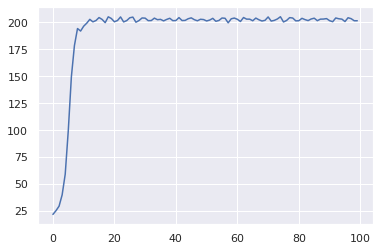

In [16]:
cartpole = VectorizedEnvWrapper(gym.make("CartPole-v0"), num_envs=8)
categorical = CategoricalPolicy(cartpole, lr=1e-2)
value_estimator = ValueEstimator(cartpole, lr=1e-2)
PPO(cartpole, categorical, value_estimator, epochs=100)

The learning curve for `CartPole-v0` is significantly steeper than for A2C. The learning is fast and stable. Compare this to the learning curve for A2C:

![cartpole-a2c.png](cartpole-a2c.png)

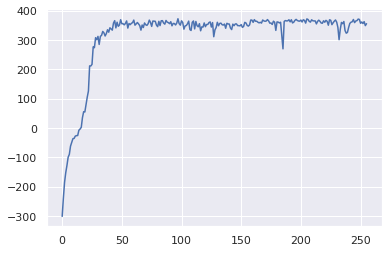

In [15]:
import gym_cartpole_swingup
swingup = VectorizedEnvWrapper(gym.make("CartPoleSwingUp-v0"), num_envs=8)
digauss = DiagonalGaussianPolicy(swingup, lr=1e-2)
value_estimator = ValueEstimator(swingup, lr=1e-1)
PPO(swingup, digauss, value_estimator, gamma=0.999, lam=0.99)

I ran 36 random seeds using these hyperparameters to get an idea of the distribution of learning, so that we can compare it to the distribution of learning for A2C. I just used the same hyperparameters as for A2C. Hyperparameters were not tuned specifically for PPO.

Learning for A2C:

![swingup-multi-a2c.png](swingup-multi-a2c.png)

Learning for PPO:

![swingup.png](swingup.png)

As we can see, the learnin curve is much steeper - every agent manages to "solve" the environment. The variability in performance that we see (random drops in performance) tend to resolve themselves extremely quickly, and decrease in magnitude with time. In contrast, only some agents using A2C reach this level of performance.


Finally, just for fun, let's look at some GIFs of the learned policies! 

In [ ]:
import imageio
from PIL import Image

def generate_gif(env, agent, filename, T=200):
    frames = []
    s_t = env.reset()
    for t in range(T):
        a_t, _ = agent.act(s_t)
        s_t, r_t, d_t = env.step(a_t)
        frame = env.envs[0].render(mode='rgb_array')
        frames.append(frame)
        print(t)

    images_list = [Image.fromarray(frame) for frame in frames]
    imageio.mimsave(f'{filename}.gif', frames, duration=0.02)

In [ ]:
generate_gif(cartpole, categorical, 'cartpole')

![cartpole.gif](cartpole.gif)

In [ ]:
generate_gif(swingup, digauss, 'swingup', T=4000)

![swingup.gif](swingup.gif)